# Preprocessing notebook

In [1]:
import polars as pl
import os
from pathlib import Path
from bs4 import BeautifulSoup
import lxml
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import functools
import re
from datetime import datetime
import spacy
import json
import time

from typing import Optional
import wordcloud
import matplotlib.pyplot as plt

In [2]:
# Configuration parameters
CONFIG = {
    "input_file": "../data/stackoverflow/stackoverflow_script.parquet",
    "output_dir": "../data/batched_processing",
    "temp_dir": "../data/batched_processing/temp",
    "log_file": "../data/batched_processing/processing_log.json",
    "batch_size": 50000,  # Records per batch
    "total_batches": None,  # Will be calculated
    "completed_batches": [],  # Will track completed batches
}

# Create necessary directories
os.makedirs(CONFIG["output_dir"], exist_ok=True)
os.makedirs(CONFIG["temp_dir"], exist_ok=True)

## Preprocessing functions

In [ ]:
def extract_text_and_code_optimized(html_content):
    """
    Efficiently separates text and code blocks from Stack Overflow HTML content
    """
    # Use lxml parser for speed
    soup = BeautifulSoup(html_content, "lxml")

    # Get all code blocks in a single pass
    code_elements = soup.find_all("code")
    code_blocks = [code.get_text() for code in code_elements]

    # Extract text after removing code (more efficient than decomposing in a loop)
    for code in code_elements:
        code.replace_with(
            " "
        )  # Replace with space instead of removing to maintain text flow

    clean_text = soup.get_text(separator=" ", strip=True)

    return {"text": clean_text, "code": code_blocks}

In [4]:
# Initialize stemmer once
stemmer = PorterStemmer()

# Create stopwords set once
standard_stops = set(stopwords.words("english"))
programming_stops = set()  # Add programming-specific stopwords if needed
combined_stops = standard_stops.union(programming_stops)


# Cache for stemmed words
@functools.lru_cache(maxsize=100000)
def cached_stem(word):
    return stemmer.stem(word)


def preprocess_text(text, remove_stops=True):
    """Process text content with optimizations"""

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stop words and apply stemming more efficiently
    if remove_stops:
        # Use generator expression instead of list comprehension
        return " ".join(
            cached_stem(token) for token in tokens if token not in combined_stops
        )
    else:
        # Use generator expression instead of list comprehension
        return " ".join(cached_stem(token) for token in tokens if token)

In [ ]:
# Load a small, efficient SpaCy model - disable components you don't need
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Create stopwords set using spaCy instead of NLTK
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
programming_stops = set()  # Add programming-specific stopwords if needed
combined_stops = spacy_stopwords.union(programming_stops)


# Cache for lemmatized words
@functools.lru_cache(maxsize=100000)
def cached_lemmatize(word):
    """Lemmatize a single word and cache the result"""
    # Process the word with the full pipeline to get lemma
    doc = nlp(word)  # Use nlp() instead of nlp.make_doc()
    return doc[0].lemma_


def preprocess_text_spacy(text, remove_stops=True):
    """Process text content with SpaCy lemmatization"""

    # Process the entire text through the pipeline
    doc = nlp(text)  # Use full nlp pipeline instead of just tokenizer

    # Apply lemmatization with stop word removal if needed
    if remove_stops:
        return " ".join(
            token.lemma_  # Access lemma_ directly from processed tokens
            for token in doc
            if token.text not in combined_stops
            and token.text.strip()
            and (
                token.is_alpha or (token.text.isalnum() and len(token.text) > 1)
            )  # Allow alphanumeric tokens
        )
    else:
        return " ".join(
            token.lemma_  # Access lemma_ directly from processed tokens
            for token in doc
            if token.text.strip()
        )

## Complete batch preprocessing pipeline

Use the Polars lazy dataframe implementation to profit from query optimization for large datasets, but still batch it, since it's too much data.

### Batch processing setup

In [6]:
# Enable Polars to use all available threads for maximum performance
pl.Config.set_streaming_chunk_size(CONFIG["batch_size"])


# Initialize processing state
def initialize_state():
    """Initialize or load the processing state"""
    if os.path.exists(CONFIG["log_file"]):
        with open(CONFIG["log_file"], "r") as f:
            return json.load(f)
    else:
        # Count total rows to calculate batches
        row_count = (
            pl.scan_parquet(CONFIG["input_file"]).select(pl.len()).collect().item()
        )
        total_batches = (row_count + CONFIG["batch_size"] - 1) // CONFIG["batch_size"]

        state = {
            "total_rows": row_count,
            "total_batches": total_batches,
            "completed_batches": [],
            "start_time": datetime.now().isoformat(),
            "last_processed_time": None,
            "processing_stats": {
                "avg_batch_time_seconds": None,
                "estimated_time_remaining": None,
            },
        }
        save_state(state)
        return state


def save_state(state):
    """Save the current processing state"""
    state["last_processed_time"] = datetime.now().isoformat()
    with open(CONFIG["log_file"], "w") as f:
        json.dump(state, f, indent=2)

### Pre-processing pipeline

In [7]:
def process_batch(batch_id, state):
    """Process a single batch of data"""
    if batch_id in state["completed_batches"]:
        print(f"Batch {batch_id} already processed, skipping.")
        return

    start_time = time.time()
    print(f"Processing batch {batch_id}/{state['total_batches']}...")

    # Calculate row offset for this batch
    offset = batch_id * CONFIG["batch_size"]

    # Process the batch
    batch_df = (
        pl.scan_parquet(CONFIG["input_file"])
        .slice(offset, CONFIG["batch_size"])
        # 1. Apply filters early to reduce data volume
        # .filter(pl.col("CreationDate") > "2023-12-31")  # Example early filter
        # .limit(100) # Use to test pipeline on a small subset
        # 2. Select only needed columns as early as possible
        .select(
            [
                "Id",
                "CreationDate",
                "Score",
                "ViewCount",
                "Title",
                "Body",
                "Tags",
                "AnswerCount",
                "CommentCount",
            ]
        )
        # 3. Process HTML content in one step
        .with_columns(
            pl.col("Body")
            .map_elements(
                extract_text_and_code_optimized,
                return_dtype=pl.Struct(
                    [pl.Field("text", pl.Utf8), pl.Field("code", pl.List(pl.Utf8))]
                ),
            )
            .alias("content"),
            # 4. Process tags in same with_columns operation
            pl.col("Tags")
            .str.strip_prefix("|")
            .str.strip_suffix("|")
            .str.split("|")
            .alias("tag_list"),
        )
        # 5. Extract struct fields and derive new columns in one operation
        .with_columns(
            pl.col("content").struct.field("text").alias("clean_text"),
            pl.col("content").struct.field("code").alias("code_blocks"),
            pl.col("tag_list").list.len().alias("tag_count"),
        )
        # 6. Apply text preprocessing only after dropping unnecessary columns
        .with_columns(
            pl.col("code_blocks").list.join("").str.len_chars().alias("code_length"),
            pl.col("Body").str.len_chars().alias("body_length"),
            pl.col("Title").str.len_chars().alias("title_length"),
        )
        .drop(["Body", "Tags", "content"])
        # 7. Apply expensive text processing operations last
        .with_columns(
            pl.col("clean_text")
            .str.to_lowercase()
            .str.strip_chars()
            .replace("", None)
            .map_elements(
                preprocess_text_spacy,
                return_dtype=pl.Utf8(),
                skip_nulls=True,
            )
            .alias("processed_text")
        )
        # 8. Set execution configuration
        .collect(
            streaming=True,
            no_optimization=False,
        )
    )

    # Save the processed batch to a parquet file
    output_file = f"{CONFIG['temp_dir']}/batch_{batch_id:04d}.parquet"
    batch_df.write_parquet(output_file)

    # Update state
    state["completed_batches"].append(batch_id)

    # Calculate processing statistics
    end_time = time.time()
    batch_time = end_time - start_time

    # Update average batch time if we have processed batches
    if not state["processing_stats"]["avg_batch_time_seconds"]:
        state["processing_stats"]["avg_batch_time_seconds"] = batch_time
    else:
        # Exponential moving average with alpha=0.3
        avg_time = state["processing_stats"]["avg_batch_time_seconds"]
        state["processing_stats"]["avg_batch_time_seconds"] = (
            avg_time * 0.7 + batch_time * 0.3
        )

    # Estimate time remaining
    remaining_batches = state["total_batches"] - len(state["completed_batches"])
    state["processing_stats"]["estimated_time_remaining"] = (
        remaining_batches * state["processing_stats"]["avg_batch_time_seconds"]
    )

    # Save updated state
    save_state(state)

    print(f"Batch {batch_id} completed in {batch_time:.2f} seconds.")
    print(
        f"Estimated time remaining: {state['processing_stats']['estimated_time_remaining'] / 3600:.2f} hours"
    )

    return batch_df

### Batching

In [ ]:
def merge_processed_batches(state):
    """Merge all processed batches into a single parquet file"""
    print("Merging processed batches...")

    # List all batch files in order
    batch_files = []
    for batch_id in range(state["total_batches"]):
        file_path = f"{CONFIG['temp_dir']}/batch_{batch_id:04d}.parquet"
        if os.path.exists(file_path):
            batch_files.append(file_path)

    if not batch_files:
        print("No processed batches found to merge.")
        return

    # Read and concatenate all batches
    merged_df = pl.concat([pl.read_parquet(file) for file in batch_files])

    # Save the merged dataframe
    output_file = f"{CONFIG['output_dir']}/stackoverflow_processed_batch1.parquet"
    merged_df.write_parquet(output_file)

    print(f"Merged {len(batch_files)} batches into {output_file}")
    return merged_df


def run_batch_processing(start_batch=None, end_batch=None):
    """Run the batch processing pipeline"""
    state = initialize_state()

    # Determine batch range to process
    if start_batch is None:
        start_batch = 0
    if end_batch is None:
        end_batch = state["total_batches"] - 1

    print(f"Starting batch processing from batch {start_batch} to {end_batch}")
    print(f"Total rows: {state['total_rows']}, Total batches: {state['total_batches']}")

    try:
        for batch_id in range(start_batch, end_batch + 1):
            process_batch(batch_id, state)
    except KeyboardInterrupt:
        print("\nProcessing interrupted. Progress has been saved.")
        print(
            f"Completed {len(state['completed_batches'])}/{state['total_batches']} batches."
        )
        return state

    print("All specified batches completed!")
    return state

### States

In [9]:
# Function to get processing progress/stats
def get_processing_status():
    """Get current processing status and stats"""
    if os.path.exists(CONFIG["log_file"]):
        with open(CONFIG["log_file"], "r") as f:
            state = json.load(f)

        completed = len(state["completed_batches"])
        total = state["total_batches"]

        print(f"Progress: {completed}/{total} batches ({completed / total * 100:.1f}%)")

        if state["processing_stats"]["avg_batch_time_seconds"]:
            avg_time = state["processing_stats"]["avg_batch_time_seconds"]
            print(f"Average batch processing time: {avg_time:.2f} seconds")

            remaining_batches = total - completed
            est_time = remaining_batches * avg_time
            print(
                f"Estimated time remaining: {est_time / 3600:.2f} hours ({est_time / 60:.2f} minutes)"
            )

        start_time = datetime.fromisoformat(state["start_time"])
        elapsed = (datetime.now() - start_time).total_seconds()
        print(f"Total elapsed time: {elapsed / 3600:.2f} hours")

        return state
    else:
        print(
            "No processing log found. Run initialize_state() to start new processing."
        )
        return None

## Run batch processing

In [10]:
# Initialize state (do this first)
state = initialize_state()

# Get current status
get_processing_status()

Progress: 0/26 batches (0.0%)
Total elapsed time: 0.17 hours


{'total_rows': 1288912,
 'total_batches': 26,
 'completed_batches': [],
 'start_time': '2025-03-07T14:50:15.343497',
 'last_processed_time': '2025-03-07T14:50:15.343522',
 'processing_stats': {'avg_batch_time_seconds': None,
  'estimated_time_remaining': None}}

In [11]:
state = run_batch_processing()

Starting batch processing from batch 0 to 25
Total rows: 1288912, Total batches: 26
Processing batch 0/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 0 completed in 411.42 seconds.
Estimated time remaining: 2.86 hours
Processing batch 1/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 1 completed in 444.97 seconds.
Estimated time remaining: 2.81 hours
Processing batch 2/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 2 completed in 422.37 seconds.
Estimated time remaining: 2.69 hours
Processing batch 3/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 3 completed in 415.94 seconds.
Estimated time remaining: 2.57 hours
Processing batch 4/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 4 completed in 414.21 seconds.
Estimated time remaining: 2.44 hours
Processing batch 5/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 5 completed in 421.82 seconds.
Estimated time remaining: 2.33 hours
Processing batch 6/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 6 completed in 484.38 seconds.
Estimated time remaining: 2.32 hours
Processing batch 7/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 7 completed in 443.18 seconds.
Estimated time remaining: 2.20 hours
Processing batch 8/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 8 completed in 466.31 seconds.
Estimated time remaining: 2.12 hours
Processing batch 9/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 9 completed in 434.80 seconds.
Estimated time remaining: 1.97 hours
Processing batch 10/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 10 completed in 430.41 seconds.
Estimated time remaining: 1.83 hours
Processing batch 11/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 11 completed in 432.89 seconds.
Estimated time remaining: 1.70 hours
Processing batch 12/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 12 completed in 516.59 seconds.
Estimated time remaining: 1.67 hours
Processing batch 13/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 13 completed in 484.40 seconds.
Estimated time remaining: 1.56 hours
Processing batch 14/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 14 completed in 450.92 seconds.
Estimated time remaining: 1.42 hours
Processing batch 15/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 15 completed in 443.65 seconds.
Estimated time remaining: 1.27 hours
Processing batch 16/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 16 completed in 381.07 seconds.
Estimated time remaining: 1.09 hours
Processing batch 17/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 17 completed in 382.51 seconds.
Estimated time remaining: 0.93 hours
Processing batch 18/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 18 completed in 410.24 seconds.
Estimated time remaining: 0.81 hours
Processing batch 19/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 19 completed in 378.89 seconds.
Estimated time remaining: 0.68 hours
Processing batch 20/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 20 completed in 388.72 seconds.
Estimated time remaining: 0.56 hours
Processing batch 21/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 21 completed in 393.64 seconds.
Estimated time remaining: 0.44 hours
Processing batch 22/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 22 completed in 427.14 seconds.
Estimated time remaining: 0.34 hours
Processing batch 23/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 23 completed in 419.68 seconds.
Estimated time remaining: 0.23 hours
Processing batch 24/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 24 completed in 416.98 seconds.
Estimated time remaining: 0.11 hours
Processing batch 25/26...


/tmp/ipykernel_129259/1668697141.py:78: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 25 completed in 325.26 seconds.
Estimated time remaining: 0.00 hours
All specified batches completed!


In [12]:
# When all batches are done, merge them
merged_df = merge_processed_batches(initialize_state())

Merging processed batches...
Merged 26 batches into ../data/batched_processing/stackoverflow_processed_batch.parquet


## EDA

In [2]:
df = pl.read_parquet("../data/batched_processing/stackoverflow_processed_batch.parquet")

In [3]:
# Calculate average text length
avg_text_length = df["processed_text"].str.len_chars().mean()
print(f"Average text length: {avg_text_length}")

Average text length: 316.50770539630247


### Wordclouds

In [4]:
def word_freq(text):
    from collections import Counter

    # Assuming 'text' is your large string
    words = text.split()
    word_freq = Counter(words)

    # If you want a regular dictionary instead of Counter
    return dict(word_freq)

In [5]:
def generate_wordcloud(title: str, text: str) -> None:
    wc = wordcloud.WordCloud(
        width=2400,
        height=1200,
        background_color="white",
        colormap="viridis",
        # stopwords=STOP_WORDS,
        mode="RGBA",
    )

    wc.generate_from_frequencies(word_freq(text))

    if title:
        wc.to_file(f"../imgs/wordclouds/{title}.png")

    # Set the figure size
    plt.figure(figsize=(16, 10))

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")

    plt.show()

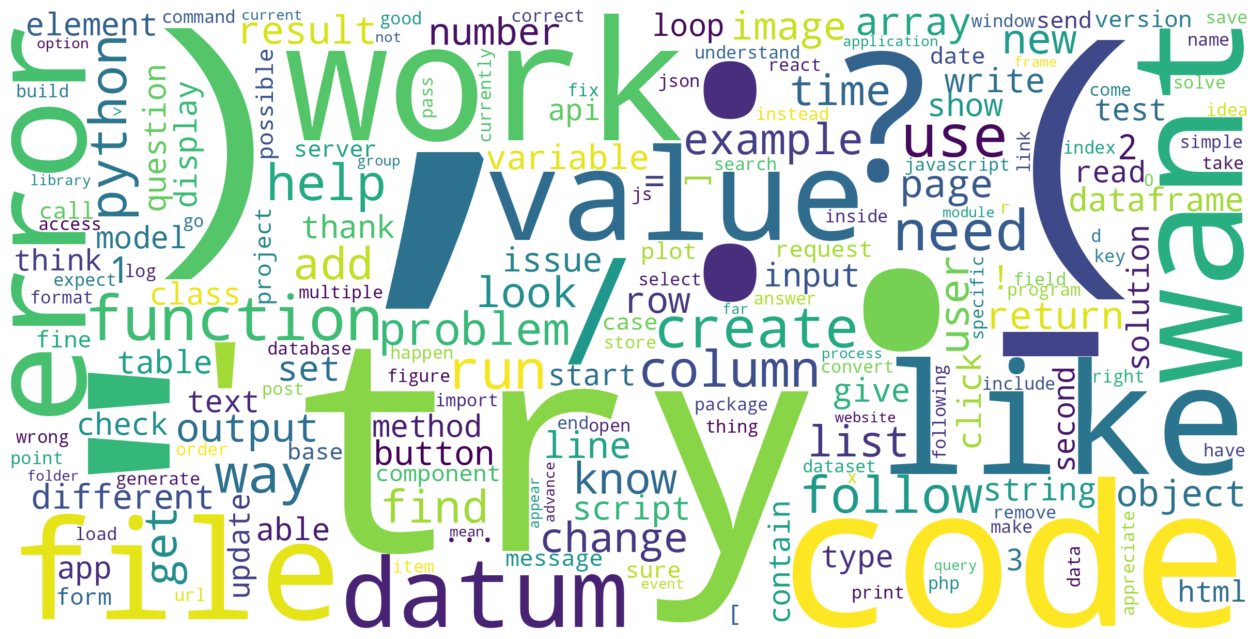

In [6]:
# Overall word cloud
text = df.select(
    pl.col("processed_text")
    .filter(pl.col("processed_text").is_not_null())
    .str.concat(" ")
).item()

generate_wordcloud("wc_stackoverflow", text)

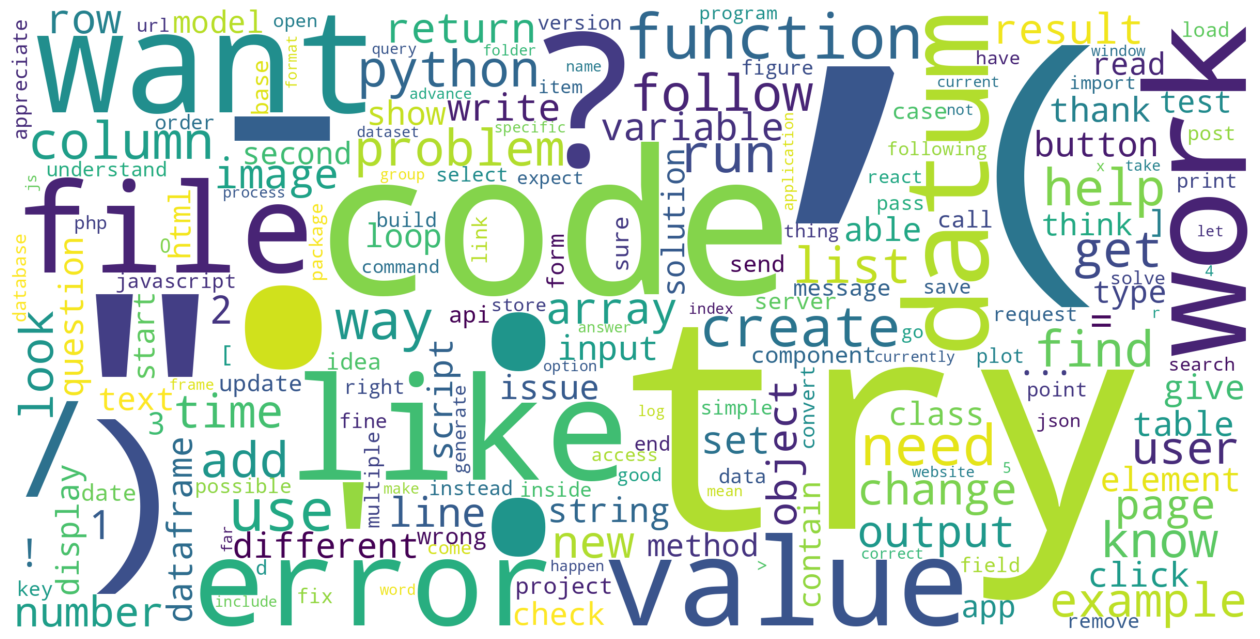

In [11]:
# Word cloud before treatment

from datetime import datetime

treatment_date = datetime(2022, 11, 30)

text = df.select(
    pl.col("processed_text")
    .filter(
        (pl.col("processed_text").is_not_null())
        & (pl.col("CreationDate").cast(pl.Datetime) <= treatment_date)
    )
    .str.concat(" ")
).item()

generate_wordcloud("wc_stackoverflow_pre", text)

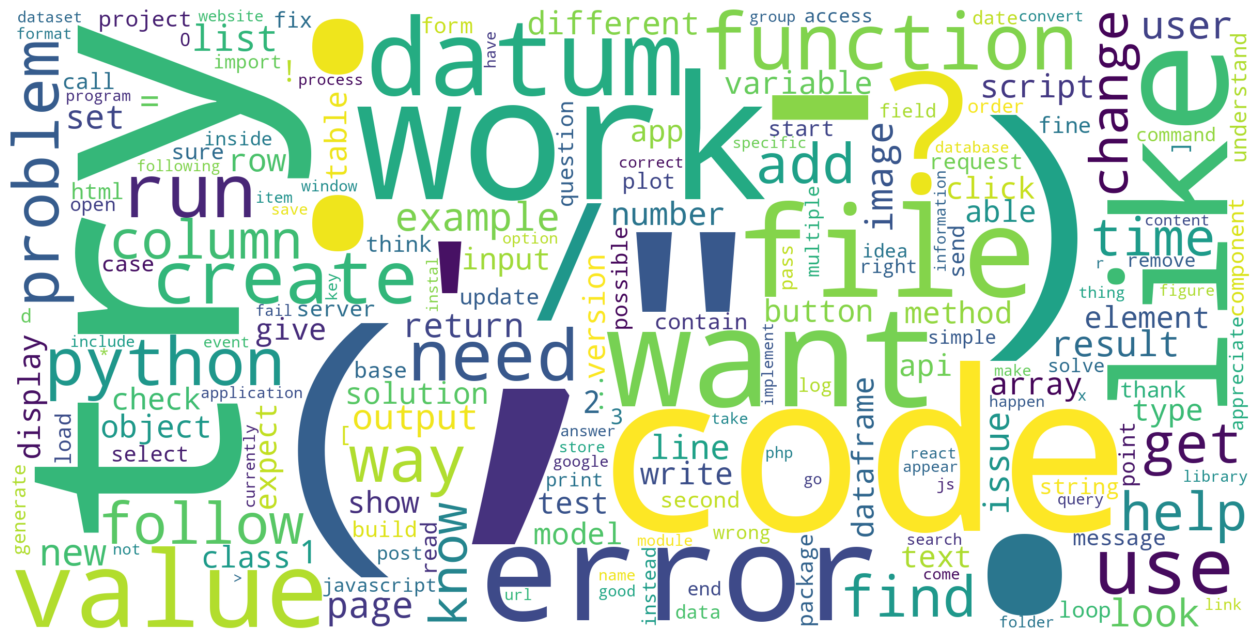

In [12]:
# Word cloud after treatment
text = df.select(
    pl.col("processed_text")
    .filter(
        (pl.col("processed_text").is_not_null())
        & (pl.col("CreationDate").cast(pl.Datetime) > treatment_date)
    )
    .str.concat(" ")
).item()

generate_wordcloud("wc_stackoverflow_post", text)